In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import cv2
import numpy as np
!pip install -U keras
!pip install tensorflow-gpu==2.1.0rc0

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
import math
import random
import keras
from keras.layers import *
from keras.models import Sequential
from keras import Model

Using TensorFlow backend.


In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class PR"

Train = ['230','232','242','263']
Test  = ['221', '229', '239', '246', '252']

# Train set patients: 230 232 242 263 
TrainX_1 = np.load(PATH + '/PR IHC 230 Images.npy')
TrainY_1 = np.load(PATH + '/PR IHC 230 Masks.npy')
TrainX_2 = np.load(PATH + '/PR IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/PR IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/PR IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/PR IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/PR IHC 263 Images.npy')
TrainY_4 = np.load(PATH + '/PR IHC 263 Masks.npy')

# Test set patients: 221 229 239 246 252
TestX_1 = np.load(PATH + '/PR IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/PR IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/PR IHC 229 Images.npy')
TestY_2 = np.load(PATH + '/PR IHC 229 Masks.npy')
TestX_3 = np.load(PATH + '/PR IHC 239 Images.npy')
TestY_3 = np.load(PATH + '/PR IHC 239 Masks.npy')
TestX_4 = np.load(PATH + '/PR IHC 246 Images.npy')
TestY_4 = np.load(PATH + '/PR IHC 246 Masks.npy')
TestX_5 = np.load(PATH + '/PR IHC 252 Images.npy')
TestY_5 = np.load(PATH + '/PR IHC 252 Masks.npy')

In [0]:
def convertToLabels(data):
  data[data==85]=1
  data[data==170]=2
  data[data==255]=3

def convertFromLabels(data):
  data[data==1]=85
  data[data==2]=170
  data[data==3]=255

In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGT = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = np.copy(TrainGT)
convertToLabels(TrainY)
TrainY = keras.utils.to_categorical(TrainY,num_classes=4,dtype='int16')

TestX = np.concatenate((TestX_1, TestX_2, TestX_3,TestX_4), axis=0)
TestGT = np.concatenate((TestY_1, TestY_2, TestY_3,TestY_4), axis=0)
TestY = np.copy(TestGT)
convertToLabels(TestY)
TestY = keras.utils.to_categorical(TestY,num_classes=4, dtype='int16')

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

In [0]:
TrainX = TrainX.astype('float32')/255
TestX = TestX.astype('float32')/255
ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(1920, 240, 240, 3)
(1920, 240, 240, 4)
(312, 240, 240, 3)
(312, 240, 240, 4)


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model(inputShape,nFilters):    
    input_layer = Input(shape=inputShape)
    block1 = get_conv_block(input_layer,nFilters,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    
    block2 = get_conv_block(dr1,nFilters*2,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    
    block3 = get_conv_block(dr2,nFilters*4,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    
    block4 = get_conv_block(dr3,nFilters*8,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(nFilters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(nFilters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(nFilters*8,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4,up1])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,nFilters*8,3)

    up2 = Conv2DTranspose(nFilters*4,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    cat2 = concatenate([block3,up2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,nFilters*4,3)
    
    up3 = Conv2DTranspose(nFilters*2,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    cat3 = concatenate([block2,up3])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,nFilters*2,3)
    
    up4 = Conv2DTranspose(nFilters,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    cat4 = concatenate([block1,up4])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,nFilters,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same')(conv10)

    model = Model(input_layer,conv11)
    return model

In [0]:
model1 = get_model((240,240,3),16)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 16) 2320        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (0.5*K.categorical_crossentropy(y_true, y_pred))+(0.75*tversky_loss(y_true, y_pred))

In [0]:
batch_size = 16
def get_batch(batch_size, X_train, Y_train): 
    size_batch = batch_size
    last_index = len(X_train) - 1
    x_train = X_train
    y_train = Y_train 
    while True:
        batch_data = [[],[]]
        for i in range(0, size_batch):
            random_index = random.randint(0, last_index)
            batch_data[0].append(x_train[random_index])
            batch_data[1].append(y_train[random_index])

        yield (np.array(batch_data[0]), np.array(batch_data[1]))     

In [0]:
from keras import backend as K      
model1.compile(loss=combined_loss, optimizer= optimizer , metrics=[dice_coef,'accuracy'])

In [0]:
num_epoch = 100
datagen = get_batch(batch_size, TrainX, TrainY)
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR"
n_points = len(TrainX)
history = model1.fit(datagen, 
                validation_data = (ValidX, ValidY),
                epochs=num_epoch,steps_per_epoch = math.ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
model1.save(MODELS_PATH + '/Laddernet_A.h5')

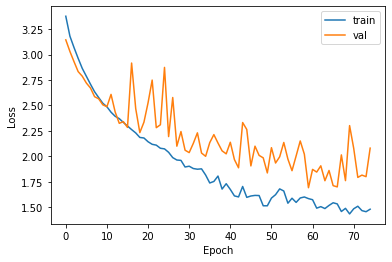

In [0]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

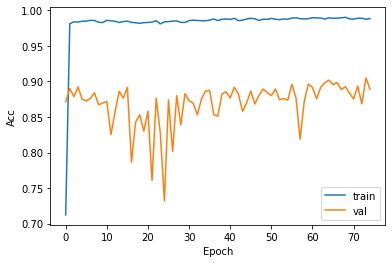

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR/"
model1 = keras.models.load_model(MODELS_PATH +'/Laddernet_A.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result   

In [0]:
trainResult = model1.predict(TrainX, batch_size=8)
validResult = model1.predict(ValidX,batch_size=8)
testResult = model1.predict(TestX,batch_size=8)

In [0]:
for i in range(trainResult.shape[0]):
  trainResult[i] = ClassFinder(trainResult[i])

for i in range(validResult.shape[0]):
  validResult[i] = ClassFinder(validResult[i])

for i in range(testResult.shape[0]):
  testResult[i] = ClassFinder(testResult[i])

In [0]:
model2 = get_model((240,240,4),4)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 240, 240, 4)  148         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 240, 240, 4)  16          conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 240, 240, 4)  148         batch_normalization_33[0][0]     
____________________________________________________________________________________________

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
datagen = get_batch(batch_size, trainResult, TrainY)
num_epoch = 75
n_points = len(trainResult)

model2.compile(loss=combined_loss, optimizer= optimizer , metrics=[dice_coef,'accuracy'])
history = model2.fit(datagen, 
                validation_data = (validResult, ValidY),
                epochs=num_epoch,steps_per_epoch = math.ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
model2.save(MODELS_PATH + '/Laddernet_B.h5')

Epoch 1/75
113/113 [==============================] - 36s 316ms/step - loss: 3.3287 - dice_coef: 0.2672 - accuracy: 0.8442 - val_loss: 3.1283 - val_dice_coef: 0.2874 - val_accuracy: 0.8855

Epoch 00001: val_loss improved from inf to 3.12831, saving model to Checkpoint.h5
Epoch 2/75
113/113 [==============================] - 29s 259ms/step - loss: 3.1678 - dice_coef: 0.3196 - accuracy: 0.9848 - val_loss: 3.0091 - val_dice_coef: 0.3309 - val_accuracy: 0.8847

Epoch 00002: val_loss improved from 3.12831 to 3.00908, saving model to Checkpoint.h5
Epoch 3/75
113/113 [==============================] - 29s 260ms/step - loss: 3.0426 - dice_coef: 0.3687 - accuracy: 0.9868 - val_loss: 2.9142 - val_dice_coef: 0.3768 - val_accuracy: 0.8840

Epoch 00003: val_loss improved from 3.00908 to 2.91425, saving model to Checkpoint.h5
Epoch 4/75
113/113 [==============================] - 29s 259ms/step - loss: 2.9368 - dice_coef: 0.4183 - accuracy: 0.9877 - val_loss: 2.8433 - val_dice_coef: 0.4210 - val_accu

In [0]:
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR/"
model1 = keras.models.load_model(MODELS_PATH +'/Laddernet_B.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
trainResult = model2.predict(trainResult, batch_size=8)
validResult = model2.predict(validResult,batch_size=8)
testResult = model2.predict(testResult,batch_size=8)

In [0]:
trainResult = np.argmax(trainResult,axis=-1)
validResult = np.argmax(validResult,axis=-1)
testResult = np.argmax(testResult,axis=-1)

convertFromLabels(trainResult)
convertFromLabels(validResult)
convertFromLabels(testResult)

print(trainResult.shape)
print(validResult.shape)
print(testResult.shape)

(1800, 240, 240)
(312, 240, 240)
(1920, 240, 240)


In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img

In [0]:
def saveNumpyOutput(mask, Patient_array,title):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id*10, id*10+10):
      print(i)
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/PR/UNET/4 Class/High Twersky/" + title + Patient_array[id], final_output)

In [0]:
# saving predicted outputs as numpy arrays for test images
Train = ['230','232','242','263']
Test  = ['221', '229', '239', '246', '252']

trainResult = np.append(trainResult,validResult,axis=0)
saveNumpyOutput(trainResult, Train,"Train/")
saveNumpyOutput(testResult, Test, "Test/")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


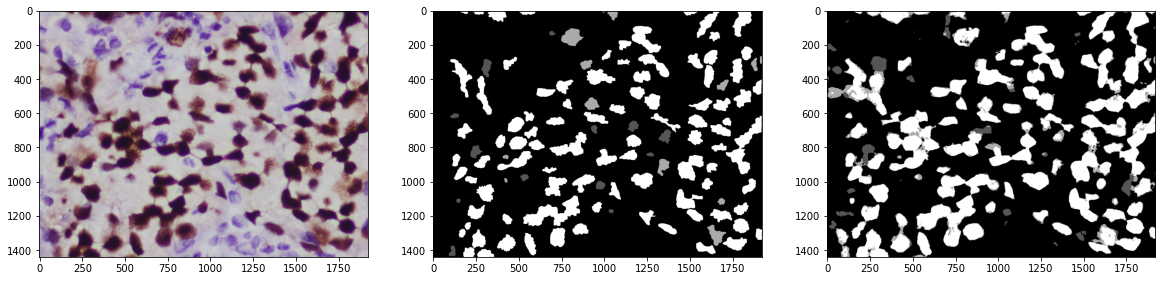

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 25   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Test_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Test_Actual)
print(Mask_input.shape)

final_output = Predicted_images_test[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')



(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[ 0. 85.]


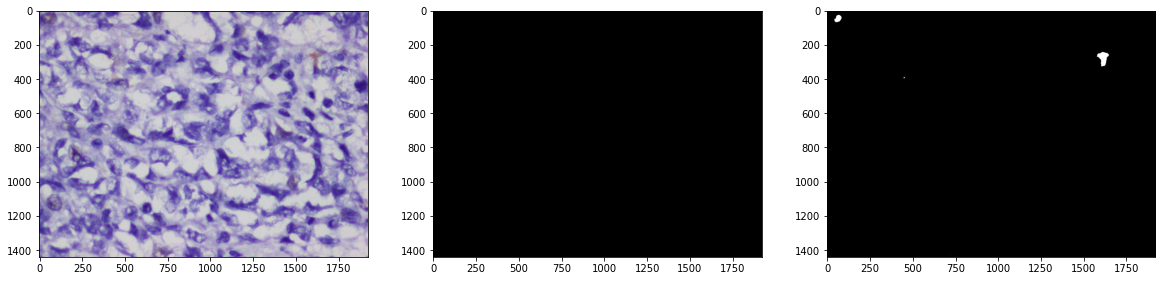

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 2  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

In [0]:
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Predicted Images/ER/UNET/4 Class/12-04-2020"
def saveImageOutput(patients, GroundTruth, Predicted, folder):
  totalimages = patients * 10
  for id in range(totalimages):
    index = id * 48
    Mask_input = GroundTruth[index:index+48]
    GroundTruth_Actual = [ ]
    for img in Mask_input:
      img = ClassFinder(img)
      encoded_img = convertFromOneHot(img)
      GroundTruth_Actual.append(encoded_img)
    Mask_input = np.asarray(GroundTruth_Actual)
    final_output = Predicted[index:index+48]
    Mask_input   = stitchMaskPatches(Mask_input)
    final_output = stitchMaskPatches(final_output)
    cv2.imwrite(SAVE_PATH +  '/Predicted Mask'+ folder + '/Image '+ str(id) + '.png', final_output)


In [0]:
saveImageOutput(3, TestY, Predicted_images_test, '/Test' )
saveImageOutput(4, TrainY, Predicted_images, '/Train' )